In [2]:
import sys
sys.version

'3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]'

In [90]:
from tqdm import tqdm
from collections import defaultdict
import math

In [3]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

/opt/anaconda3/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping


## Реализуем крестики-нолики

In [4]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [694]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def _check_terminal(self, cur_p):
        cur_marks = np.where(self.board == cur_p)
        for i,j in zip(cur_marks[0], cur_marks[1]):
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    return True
            if j <= self.n_cols - self.n_win:
                if np.all(self.board[i,j:j+self.n_win] == cur_p):
                    return True
            if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                    return True
            if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                    return True
        return False
    
    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_win = self._check_terminal(self.curTurn)
        if cur_win:
                self.gameOver = True
                return self.curTurn
            
        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def getWinner(self):
        # фактически запускаем isTerminal два раза для крестиков и ноликов
        if self._check_terminal(1):
            return 1
        if self._check_terminal(-1):
            return -1
        if len(self.getEmptySpaces()) == 0:
            return 0
        return None
    
    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [695]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
plot_test_game(env, None, None, random_crosses=True)

-------------
|   |   |   | 
-------------
| x |   |   | 
-------------
|   |   |   | 
-------------
-------------
|   |   |   | 
-------------
| x |   |   | 
-------------
|   | o |   | 
-------------
-------------
|   |   | x | 
-------------
| x |   |   | 
-------------
|   | o |   | 
-------------
-------------
|   |   | x | 
-------------
| x |   |   | 
-------------
|   | o | o | 
-------------
-------------
|   |   | x | 
-------------
| x |   |   | 
-------------
| x | o | o | 
-------------
-------------
| o |   | x | 
-------------
| x |   |   | 
-------------
| x | o | o | 
-------------
-------------
| o | x | x | 
-------------
| x |   |   | 
-------------
| x | o | o | 
-------------
-------------
| o | x | x | 
-------------
| x |   | o | 
-------------
| x | o | o | 
-------------
-------------
| o | x | x | 
-------------
| x | x | o | 
-------------
| x | o | o | 
-------------
Крестики выиграли!


# Q-learning

## 3x3

In [696]:
def n_ones(x, max_pow):
    res = 0
    for i in range(max_pow):
        if x % 3 == 1:
            res += 1
        x = x // 3
    return res

### Крестики

In [697]:
def Q_learning_episode_x(env, Q, n_ceils, alpha=0.05, epsilon=0.0, gamma=0.9, rng=None):
    env.reset()
    s = int(env.getHash(), 3)
    if Q[s] is None:
        Q[s] = np.array([np.random.random() for _ in range(n_ones(s, n_ceils))])
    if np.random.rand() > epsilon:
        a_id = np.argmax(Q[s])
    else:
        a_id = np.random.randint(len(Q[s]))
    a = env.getEmptySpaces()[a_id]
    
    for i in range(1000):
        _, reward, done, _ = env.step(a)
        if not done:
            _, reward, done, _ = env.step(rng.choice(env.getEmptySpaces()))
        
        s_prime = int(env.getHash(), 3)
        if Q[s_prime] is None:
            Q[s_prime] = np.array([np.random.random() for _ in range(n_ones(s_prime, n_ceils))])
        max_sprime = np.max( Q[s_prime] ) if len(Q[s_prime]) > 0 else env.getWinner()
        Q[s][a_id] = Q[s][a_id] + alpha * (reward + gamma * max_sprime - Q[s][a_id])
        if done:
            break
        empty_spaces = env.getEmptySpaces()
        if np.random.rand() > epsilon:
            a_id = np.argmax(Q[s_prime])
        else:
            a_id = np.random.randint(len(Q[s_prime]))
        s, a = s_prime, empty_spaces[a_id]
    return env.getWinner()

In [698]:
n_rows, n_cols = 3, 3
env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=3)
n_ceils = n_rows * n_cols
total_episodes = 100000
gamma = 0.9

rewards = np.zeros(total_episodes, dtype=int)

Q = [None for _ in range(3 ** n_ceils)]
epsilon = 0.1
rng = np.random.default_rng()

for n in tqdm(range(total_episodes)):
    if np.sqrt(n / 100) % 1 == 0:
        epsilon = epsilon / 2
    rewards[n] = Q_learning_episode_x(env, Q, n_ceils=n_ceils, alpha=0.1, epsilon=epsilon, gamma=gamma, rng=rng)

100%|██████████| 100000/100000 [00:42<00:00, 2344.24it/s]


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'win ratio')

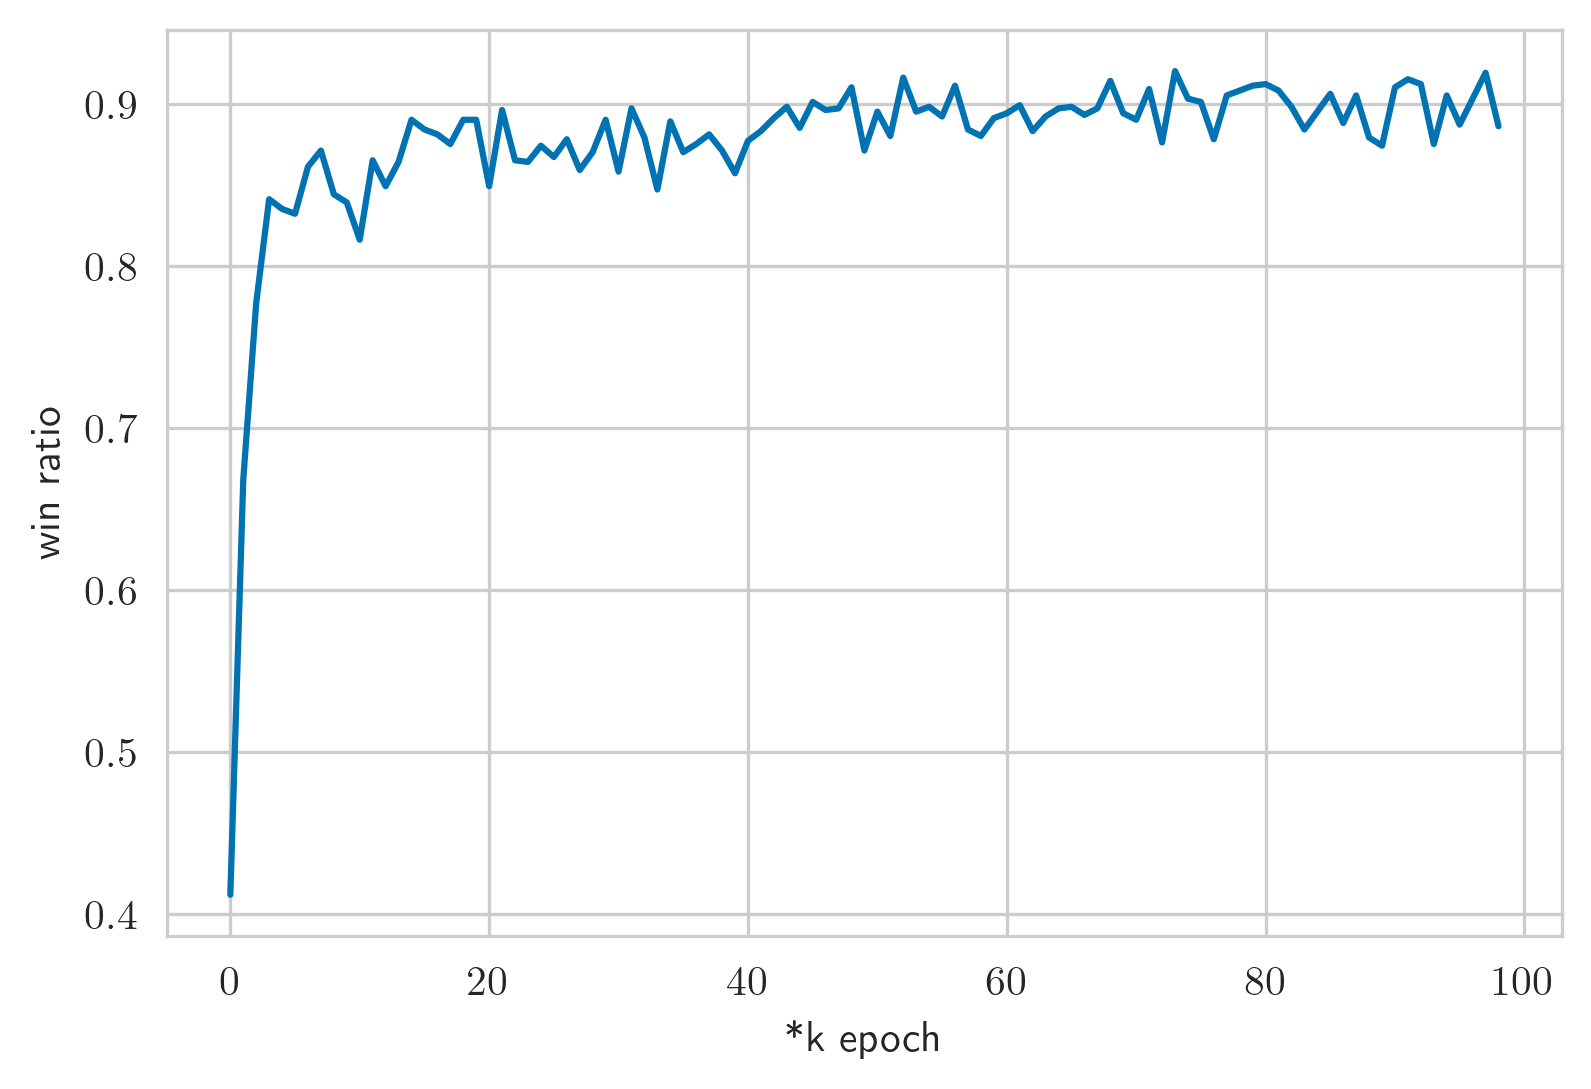

In [701]:
plt.plot([sum(rewards[(i * 1000): ((i + 1) * 1000)]) / 1000 for i in range(99)])
plt.xlabel('k epoch')
plt.ylabel('win ratio')

### Нолики

In [702]:
def Q_learning_episode_o(env, Q, n_ceils, alpha=0.05, epsilon=0.0, gamma=0.9, rng=None):
    env.reset()
    env.step(rng.choice(env.getEmptySpaces()))
    s = int(env.getHash(), 3)
    if Q[s] is None:
        Q[s] = np.array([np.random.random() for _ in range(n_ones(s, n_ceils))])
    if np.random.rand() > epsilon:
        a_id = np.argmax(Q[s])
    else:
        a_id = np.random.randint(len(Q[s]))
    a = env.getEmptySpaces()[a_id]
    
    for i in range(1000):
        _, reward, done, _ = env.step(a)
        if not done:
            _, reward, done, _ = env.step(rng.choice(env.getEmptySpaces()))
        
        s_prime = int(env.getHash(), 3)
        if Q[s_prime] is None:
            Q[s_prime] = np.array([np.random.random() for _ in range(n_ones(s_prime, n_ceils))])
        max_sprime = np.max( Q[s_prime] ) if len(Q[s_prime]) > 0 else -env.getWinner()
        Q[s][a_id] = Q[s][a_id] + alpha * (-reward + gamma * max_sprime - Q[s][a_id])
        if done:
            break
        empty_spaces = env.getEmptySpaces()
        if np.random.rand() > epsilon:
            a_id = np.argmax(Q[s_prime])
        else:
            a_id = np.random.randint(len(Q[s_prime]))
        s, a = s_prime, empty_spaces[a_id]
    return -env.getWinner()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [703]:
n_rows, n_cols = 3, 3
env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=3)
n_ceils = n_rows * n_cols
total_episodes = 100000
gamma = 0.9

rewards = np.zeros(total_episodes, dtype=int)

Q = [None for _ in range(3 ** n_ceils)]
epsilon = 0.1
rng = np.random.default_rng()

for n in tqdm(range(total_episodes)):
    if np.sqrt(n / 100) % 1 == 0:
        epsilon = epsilon / 2
    rewards[n] = Q_learning_episode_o(env, Q, n_ceils=n_ceils, alpha=0.1, epsilon=epsilon, gamma=gamma, rng=rng)

100%|██████████| 100000/100000 [00:47<00:00, 2110.49it/s]


Text(0, 0.5, 'win ratio')

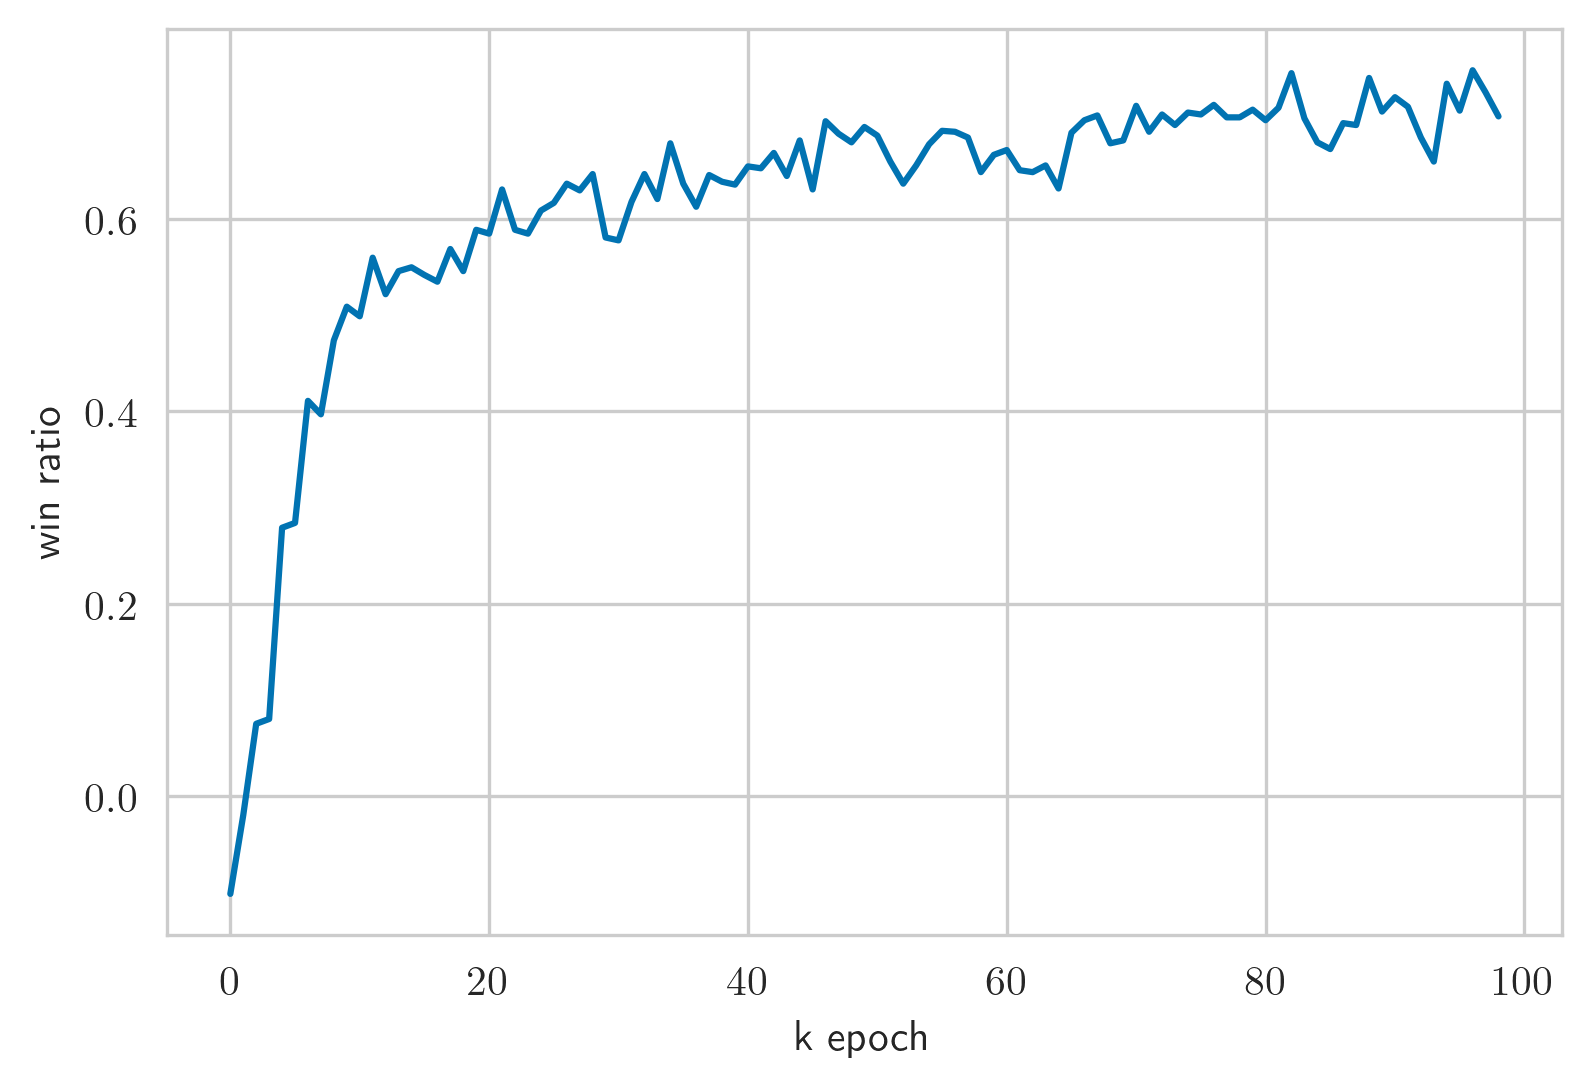

In [704]:
plt.plot([sum(rewards[(i * 1000): ((i + 1) * 1000)]) / 1000 for i in range(99)])
plt.xlabel('k epoch')
plt.ylabel('win ratio')

## 4x4

In [73]:
n_rows, n_cols = 4, 4
env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=4)
n_ceils = n_rows * n_cols

total_episodes = 400000
gamma = 0.9

rewards = np.zeros(total_episodes, dtype=int)

Q = [None for _ in range(3 ** n_ceils)]
epsilon = 0.1
rng = np.random.default_rng()

for n in tqdm(range(total_episodes)):
#     if np.sqrt(n / 100) % 1 == 0:
#         epsilon = epsilon / 2
    rewards[n] = Q_learning_episode_x(env, Q, n_ceils=n_ceils, alpha=0.1, epsilon=epsilon, gamma=gamma, rng=rng)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 400000/400000 [08:39<00:00, 769.47it/s]


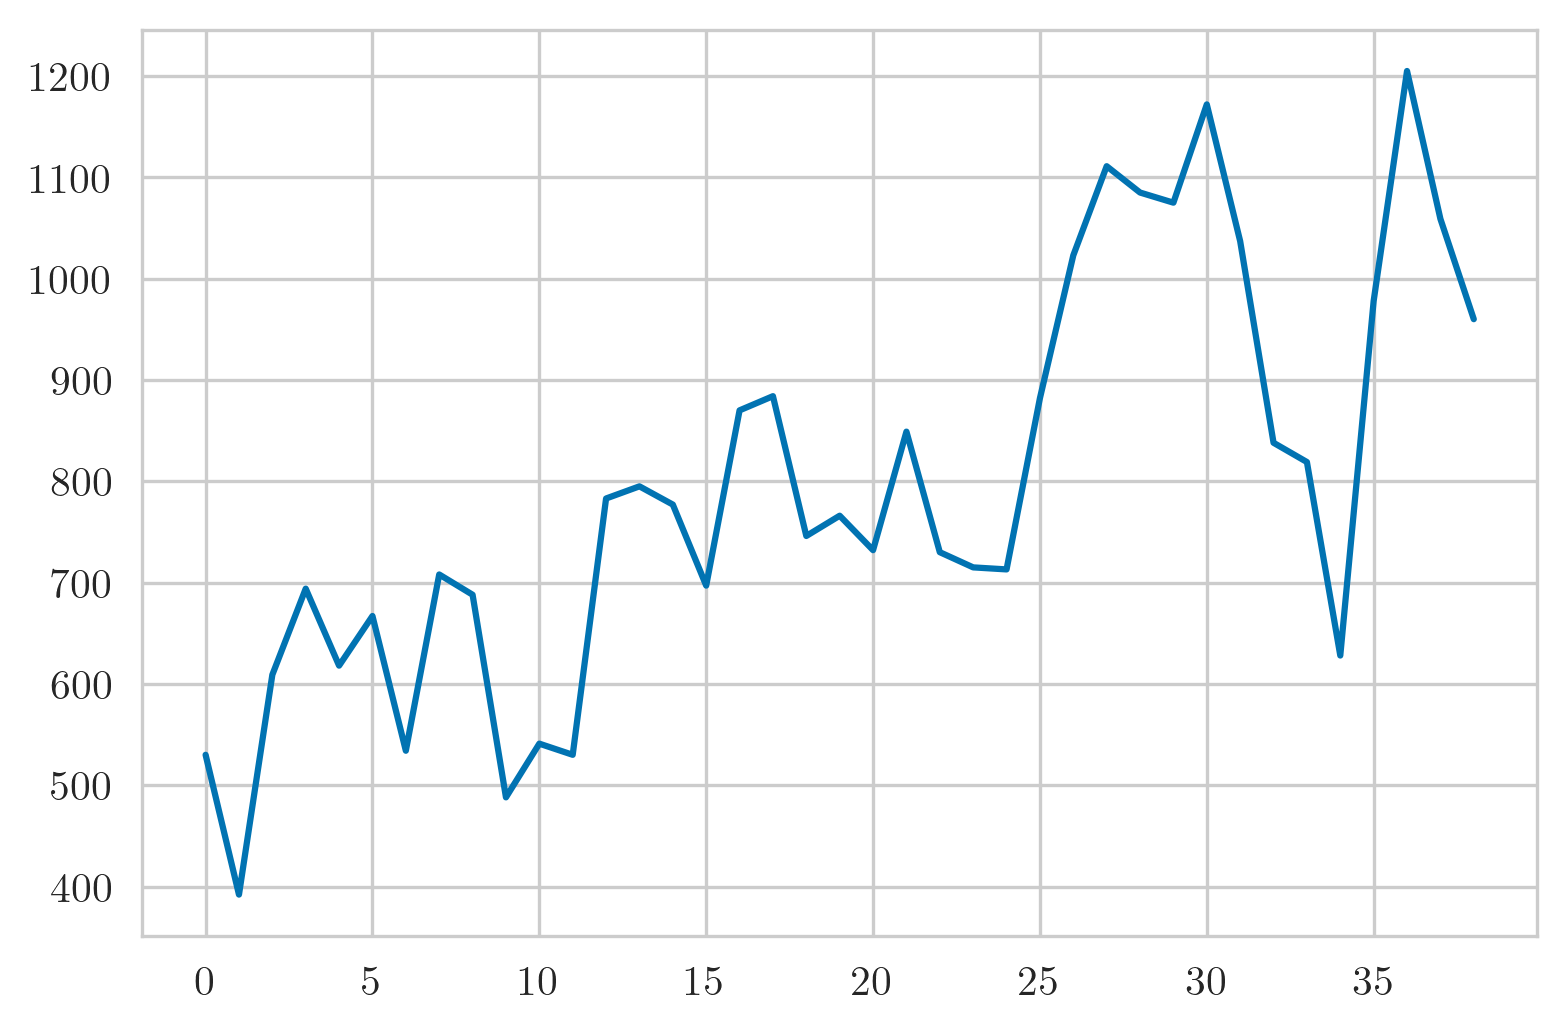

In [74]:
plt.plot([sum(rewards[(i * 10000): ((i + 1) * 10000)]) for i in range(39)])

Ползем вверх, но epsilon decay не смог подобрать

# MCTS

Я решил написать новый env, потому что не удобно ходить по старой так как хочу просто держать состояние, менять его и искать те которые могу сделать 

### 3x3

In [705]:
WIN_COMBOS = (
    [(i, i + 1, i + 2) for i in range(0, 9, 3)] + [(i, i + 3, i + 6) for i in range(3)] + [(0, 4, 8), (2, 4, 6)]
)

class myEnv_3:
    def __init__(self, state, turn, winner, terminal):
        self.state = state
        self.turn = turn
        self.winner = winner 
        self.terminal = terminal
        
    def next_states(self):
        if self.terminal: 
            return set()
        
        return {
            self.step(i) for i, pos in enumerate(self.state) if pos is None
        }

    def next_random_state(self):
        if self.terminal:
            return None  
        empty_spots = [i for i, pos in enumerate(self.state) if pos is None]
        return self.step(np.random.choice(empty_spots))
    
    def reward(self):
        if not self.terminal:
            return None
        if self.winner is self.turn:
            return None
        if self.turn is (not self.winner):
            return -1
        if self.winner is None:
            return 0
        return None
    
    def step(self, index):
        state = self.state[:index] + (self.turn,) + self.state[index + 1 :]
        turn = not self.turn
        winner = self._find_winner(state)
        is_terminal = (winner is not None) or not any(v is None for v in state)
        return myEnv_3(state, turn, winner, is_terminal)
    
    def show(self):
        f = lambda v: ("X" if v is True else ("O" if v is False else " "))
        rows = [
            [f(self.state[3 * row + col]) for col in range(3)] for row in range(3)
        ]
        return (
            "\n  1 2 3\n"
            + "\n".join(str(i + 1) + " " + " ".join(row) for i, row in enumerate(rows))
            + "\n"
        )
    
    
    def _find_winner(self, state):
        for i1, i2, i3 in WIN_COMBOS:
            v1, v2, v3 = state[i1], state[i2], state[i3]
            if False is v1 is v2 is v3:
                return False
            if True is v1 is v2 is v3:
                return True
        return None
    
    @staticmethod
    def new():
        return myEnv_3(state=(None,) * 9, turn=True, winner=None, terminal=False)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [706]:
class MCTS:
    def __init__(self, c=1):
        self.Q = defaultdict(int)
        self.N = defaultdict(int)
        self.children = dict()
        self.c = c

    def choose(self, node):
        if node not in self.children:
            return node.next_random_state()

        def score(n):
            if self.N[n] == 0:
                return float("-inf")
            return self.Q[n] / self.N[n]

        return max(self.children[node], key=score)

    def do_rollout(self, node):
        path = self._select(node)
        leaf = path[-1]
        self._expand(leaf)
        reward = self._simulate(leaf)
        self._backpropagate(path, reward)

    def _select(self, node):
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                return path
            unexplored = self.children[node] - self.children.keys()
            if unexplored:
                n = unexplored.pop()
                path.append(n)
                return path
            node = self._uct_select(node)

    def _expand(self, node):
        if node in self.children:
            return
        self.children[node] = node.next_states()

    def _simulate(self, node):
        invert_reward = True
        while True:
            if node.terminal:
                reward = node.reward()
                return 1 - reward if invert_reward else reward
            node = node.next_random_state()
            invert_reward = not invert_reward

    def _backpropagate(self, path, reward):
        for node in reversed(path):
            self.N[node] += 1
            self.Q[node] += reward
            reward = - reward

    def _uct_select(self, node):
        assert all(n in self.children for n in self.children[node])

        log_N_vertex = np.log(self.N[node])

        def uct(n):
            return self.Q[n] / self.N[n] + self.c * math.sqrt(
                log_N_vertex / self.N[n]
            )

        return max(self.children[node], key=uct)

### Нолики

In [708]:
def run_exp_3_o():
    tree = MCTS()
    env = myEnv_3.new()
    while True:
        env = env.next_random_state()
        if env.terminal:
            return env._find_winner(env.state)
        for _ in range(200):
            tree.do_rollout(env)
        env = tree.choose(env)
        if env.terminal:
            return env._find_winner(env.state)

    return env._find_winner(env.state)

N_IT = 1000

res = 0
for i in tqdm(range(N_IT)):
    win = run_exp_3_o()
    if win is None:
        continue
    if win:
        res += -1
    else:
        res += 1
    
print('Win ratio', res / N_IT)

100%|██████████| 1000/1000 [00:41<00:00, 24.09it/s]

Win ratio 0.852


### 4x4

In [711]:
WIN_COMBOS = (
    [(i, i + 1, i + 2, i + 3) for i in range(0, 12, 4)] + \
    [(i, i + 4, i + 8, i + 12) for i in range(4)] + \
    [(0, 5, 10, 15), (3, 6, 9, 12)]
)

class myEnv_4:
    def __init__(self, state, turn, winner, terminal):
        self.state = state
        self.turn = turn
        self.winner = winner 
        self.terminal = terminal
        
    def next_states(self):
        if self.terminal: 
            return set()
        
        return {
            self.step(i) for i, pos in enumerate(self.state) if pos is None
        }

    def next_random_state(self):
        if self.terminal:
            return None  
        empty_spots = [i for i, pos in enumerate(self.state) if pos is None]
        return self.step(np.random.choice(empty_spots))
    
    def reward(self):
        if not self.terminal:
            return None
        if self.winner is self.turn:
            return None
        if self.turn is (not self.winner):
            return -1
        if self.winner is None:
            return 0
        return None
    
    def step(self, index):
        state = self.state[:index] + (self.turn,) + self.state[index + 1 :]
        turn = not self.turn
        winner = self._find_winner(state)
        is_terminal = (winner is not None) or not any(v is None for v in state)
        return myEnv_4(state, turn, winner, is_terminal)
    
    def show(self):
        f = lambda v: ("X" if v is True else ("O" if v is False else " "))
        rows = [
            [f(self.state[4 * row + col]) for col in range(4)] for row in range(4)
        ]
        return (
            "\n  1 2 3 4\n"
            + "\n".join(str(i + 1) + " " + " ".join(row) for i, row in enumerate(rows))
            + "\n"
        )
    
    
    def _find_winner(self, state):
        for i1, i2, i3, i4 in WIN_COMBOS:
            v1, v2, v3, v4 = state[i1], state[i2], state[i3], state[i4]
            if False is v1 is v2 is v3 is v4:
                return False
            if True is v1 is v2 is v3 is v4:
                return True
        return None
    
    @staticmethod
    def new():
        return myEnv_4(state=(None,) * 16, turn=True, winner=None, terminal=False)

In [712]:
def run_exp_4():
    tree = MCTS()
    env = myEnv_4.new()
    while True:
        for _ in range(200):
            tree.do_rollout(env)
        env = tree.choose(env)
        if env.terminal:
            return env._find_winner(env.state)
        env = env.next_random_state()
        if env.terminal:
            return env._find_winner(env.state)

    return env._find_winner(env.state)

N_IT = 1000

res = 0
for i in tqdm(range(N_IT)):
    win = run_exp_4()
    if win is None:
        continue
    if win:
        res += 1
    else:
        res += -1
    
print('Win ratio', res / N_IT)

100%|██████████| 1000/1000 [04:01<00:00,  4.13it/s]

Win ratio 0.903


Из хорошего он сходится для 4х4 и можно против него играть. Качество судя по 3х3 даже лучше чем в 1ом (с DQN сравню, если успею ее завести) + если она играет сама против себя всегда старается свести в ничью, что тоже выглядит красиво

# DQN

In [674]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from collections import namedtuple, deque
from torch.autograd import Variable


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [675]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [676]:
class Network(nn.Module):
    def __init__(self, layer_size=256):
        nn.Module.__init__(self)
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=2), 
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=5, stride=1),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=2), 
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=2), 
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2592, 256),
            nn.ReLU(),
            nn.Linear(256, 9)
        )

    def forward(self, x):
        return self.net(x)

In [677]:
class DQN(nn.Module):

    def __init__(self, env):
        nn.Module.__init__(self)
        self.env = env
        self.model = Network()
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        self.rng = np.random.default_rng()
        self.gamma = 0.8
        self.batch_size = 64
        self.num_step = 0
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.rewards = []
        self.debug = {}
        
    def env_state(self):
        x = torch.FloatTensor([[int(x) for x in self.env.getHash()]])
        player1 = torch.zeros(x.size()).masked_scatter_((x == 0), torch.ones(x.size())).view(-1, 3, 3)
        empty = torch.zeros(x.size()).masked_scatter_((x == 1), torch.ones(x.size())).view(-1, 3, 3)
        player2 = torch.zeros(x.size()).masked_scatter_((x == 2), torch.ones(x.size())).view(-1, 3, 3)
        cnn_input = torch.stack((empty, player1, player2), dim=1)
        return cnn_input
        
    def select_greedy_action(self, state):
        return self.model(self.env_state()).max(1)[1].view(1, 1)

    def select_action(self, state):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state)
        else:
            x = torch.FloatTensor([int(x) for x in self.env.getHash()])
            empty = torch.zeros(x.size()).masked_scatter_((x == 1), torch.ones(x.size())).view(-1)
            return torch.tensor([[np.random.choice(empty.nonzero().view(-1))]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True, greedy=False, render=False):
        self.env.reset()
        num_step = 0
        done = False
        while True:
            if render:
                self.env.printBoard()
                print(done)
            state_tensor = self.env_state()
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(state_tensor)
                else:
                    action = self.select_action(state_tensor)
                 
            pos = action.numpy()[0][0]
            x, y = pos // 3, pos % 3
            
            _, reward, done, _ = self.env.step((x, y))
            #done = self.env.getWinner() is not None
            if not done:
                _, reward, done, _ = self.env.step(self.rng.choice(self.env.getEmptySpaces()))  
            #done = self.env.getWinner() is not None
            next_state_tensor = self.env_state()

            transition = (state_tensor, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
            self.memory.store(transition)

            if do_learning:
                self.learn()
            
            if done:
                if e % 100 == 0:
                    print("\tepisode %d finished with reward %d" % (e, reward))
                self.rewards.append(reward)
                break

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
        
        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        # считаем значения функции Q
        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)
        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        #print(loss.item())

In [684]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
dqn = DQN(env)

print("%s\tStarting training for 300 episodes..." % (datetime.now().time()))
for e in range(3000):
    dqn.run_episode(e)
print("%s\t\t...done!" % (datetime.now().time()))

23:20:15.351708	Starting training for 300 episodes...
	episode 0 finished with reward 1
	episode 100 finished with reward 1
	episode 200 finished with reward -1
	episode 300 finished with reward 1
	episode 400 finished with reward 1
	episode 500 finished with reward 1
	episode 600 finished with reward -10
	episode 700 finished with reward 1
	episode 800 finished with reward 1
	episode 900 finished with reward 1
	episode 1000 finished with reward 1
	episode 1100 finished with reward 1
	episode 1200 finished with reward 1
	episode 1300 finished with reward -10
	episode 1400 finished with reward 1
	episode 1500 finished with reward 1
	episode 1600 finished with reward 1
	episode 1700 finished with reward 1
	episode 1800 finished with reward 1
	episode 1900 finished with reward 1
	episode 2000 finished with reward 1
	episode 2100 finished with reward 1
	episode 2200 finished with reward 1
	episode 2300 finished with reward 1
	episode 2400 finished with reward 1
	episode 2500 finished with 

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


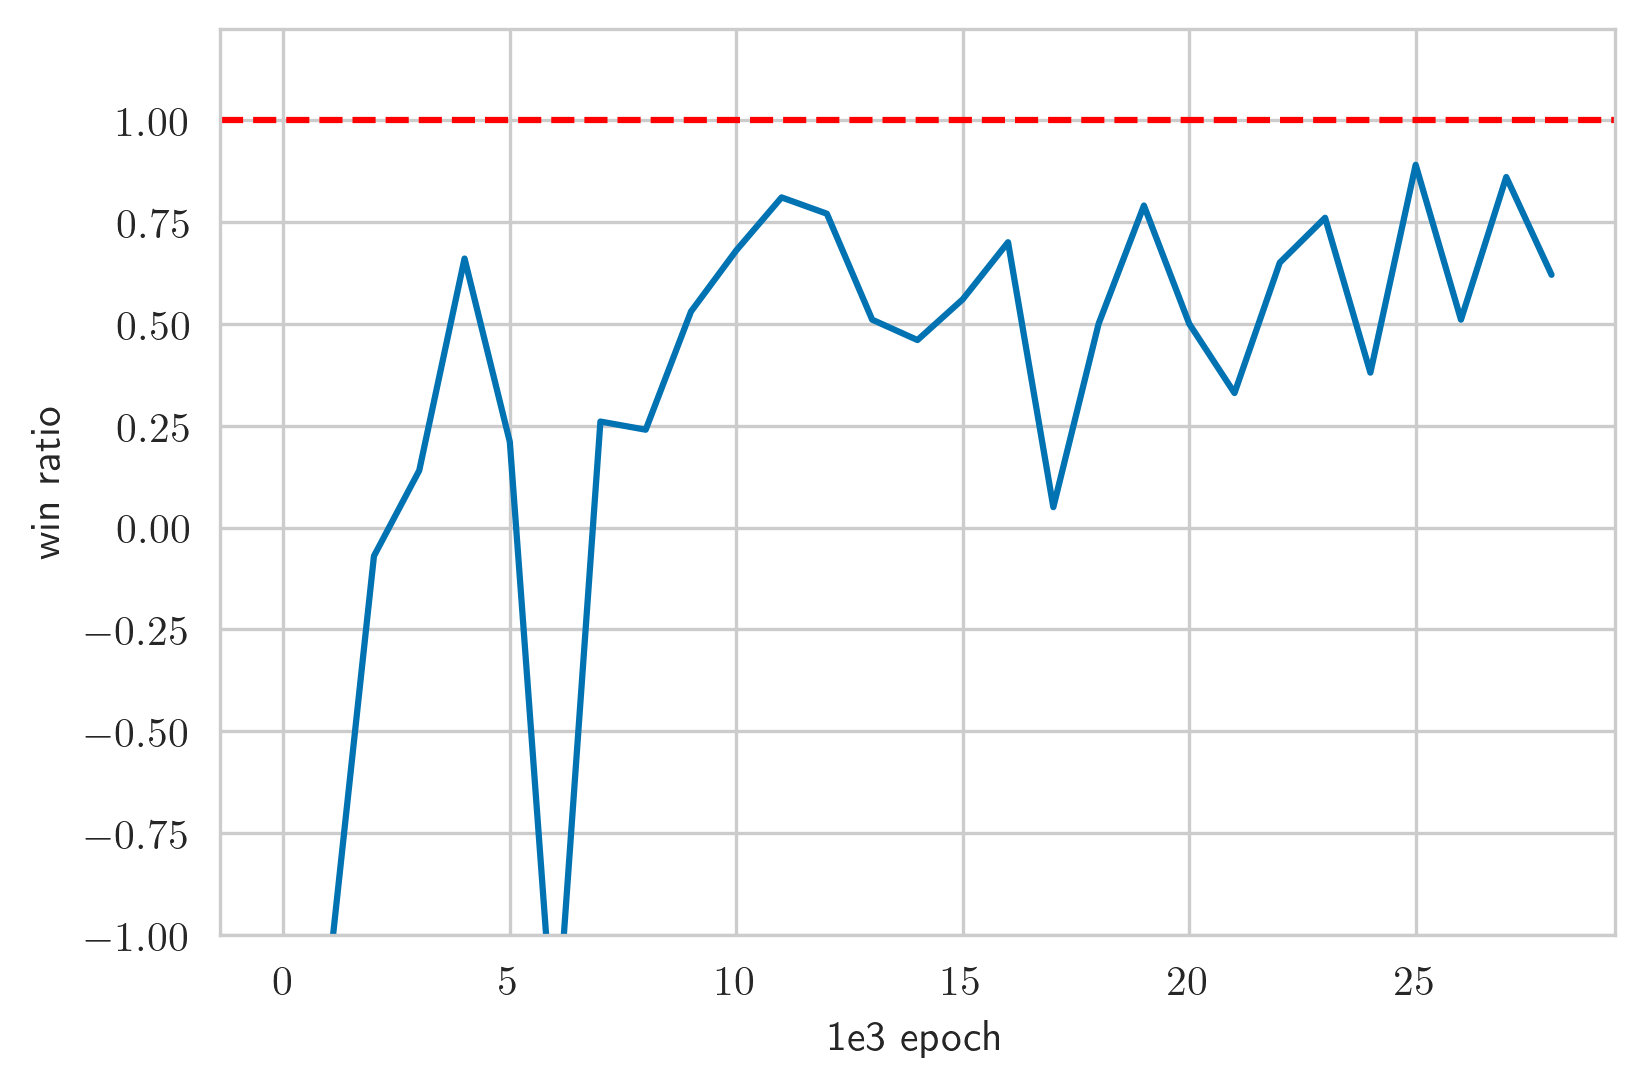

In [716]:
plt.plot([sum(dqn.rewards[(i * 100): ((i + 1) * 100)]) / 100  for i in range(29)])
plt.ylim(bottom=-1)
plt.ylabel('win ratio')
plt.xlabel('1e3 epoch')
plt.axhline(y=1, color='r', linestyle='--')

Если сравинвать DQN с MCTS, то MCTS лучше сходится (чаще выигрывает чем обученная DQN) 

### Double-DQN

In [687]:
class DDQN(nn.Module):

    def __init__(self, env):
        nn.Module.__init__(self)
        self.env = env
        self.model_a = Network()
        self.model_b = Network()
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model_a.parameters(), 0.001)
        self.rng = np.random.default_rng()
        self.gamma = 0.8
        self.batch_size = 64
        self.num_step = 0
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.rewards = []
        self.debug = {}
        
    def env_state(self):
        x = torch.FloatTensor([[int(x) for x in self.env.getHash()]])
        player1 = torch.zeros(x.size()).masked_scatter_((x == 0), torch.ones(x.size())).view(-1, 3, 3)
        empty = torch.zeros(x.size()).masked_scatter_((x == 1), torch.ones(x.size())).view(-1, 3, 3)
        player2 = torch.zeros(x.size()).masked_scatter_((x == 2), torch.ones(x.size())).view(-1, 3, 3)
        cnn_input = torch.stack((empty, player1, player2), dim=1)
        return cnn_input
        
    def select_greedy_action(self, state):
        return self.model_a(self.env_state()).max(1)[1].view(1, 1)

    def select_action(self, state):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state)
        else:
            x = torch.FloatTensor([int(x) for x in self.env.getHash()])
            empty = torch.zeros(x.size()).masked_scatter_((x == 1), torch.ones(x.size())).view(-1)
            return torch.tensor([[np.random.choice(empty.nonzero().view(-1))]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True, greedy=False, render=False):
        self.env.reset()
        num_step = 0
        done = False
        while True:
            if render:
                self.env.printBoard()
                print(done)
            state_tensor = self.env_state()
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(state_tensor)
                else:
                    action = self.select_action(state_tensor)
                 
            pos = action.numpy()[0][0]
            x, y = pos // 3, pos % 3
            
            _, reward, done, _ = self.env.step((x, y))
            #done = self.env.getWinner() is not None
            if not done:
                _, reward, done, _ = self.env.step(self.rng.choice(self.env.getEmptySpaces()))  
            #done = self.env.getWinner() is not None
            next_state_tensor = self.env_state()

            transition = (state_tensor, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
            self.memory.store(transition)

            if do_learning:
                self.learn()
            
            if done:
                if e % 100 == 0:
                    print("\tepisode %d finished with reward %d" % (e, reward))
                self.rewards.append(reward)
                break

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
        
        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        # считаем значения функции Q
        Q = self.model_a(batch_state).gather(1, batch_action).reshape([self.batch_size])
        
        next_q_values = self.model_a(batch_next_state)
        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model_b(batch_next_state).detach().gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
        Qnext = batch_reward + (self.gamma * Qmax)
        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        #print(loss.item())

In [688]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
ddqn = DDQN(env)

print("%s\tStarting training for 300 episodes..." % (datetime.now().time()))
for e in range(3000):
    ddqn.run_episode(e)
print("%s\t\t...done!" % (datetime.now().time()))

23:23:36.156504	Starting training for 300 episodes...
	episode 0 finished with reward -10
	episode 100 finished with reward 0
	episode 200 finished with reward 1
	episode 300 finished with reward 1
	episode 400 finished with reward 1
	episode 500 finished with reward 1
	episode 600 finished with reward 1
	episode 700 finished with reward 1
	episode 800 finished with reward 1
	episode 900 finished with reward 1
	episode 1000 finished with reward 1
	episode 1100 finished with reward 1
	episode 1200 finished with reward 1
	episode 1300 finished with reward 1
	episode 1400 finished with reward 1
	episode 1500 finished with reward -1
	episode 1600 finished with reward 1
	episode 1700 finished with reward 1
	episode 1800 finished with reward 1
	episode 1900 finished with reward 1
	episode 2000 finished with reward 1
	episode 2100 finished with reward 1
	episode 2200 finished with reward 1
	episode 2300 finished with reward 1
	episode 2400 finished with reward 1
	episode 2500 finished with re

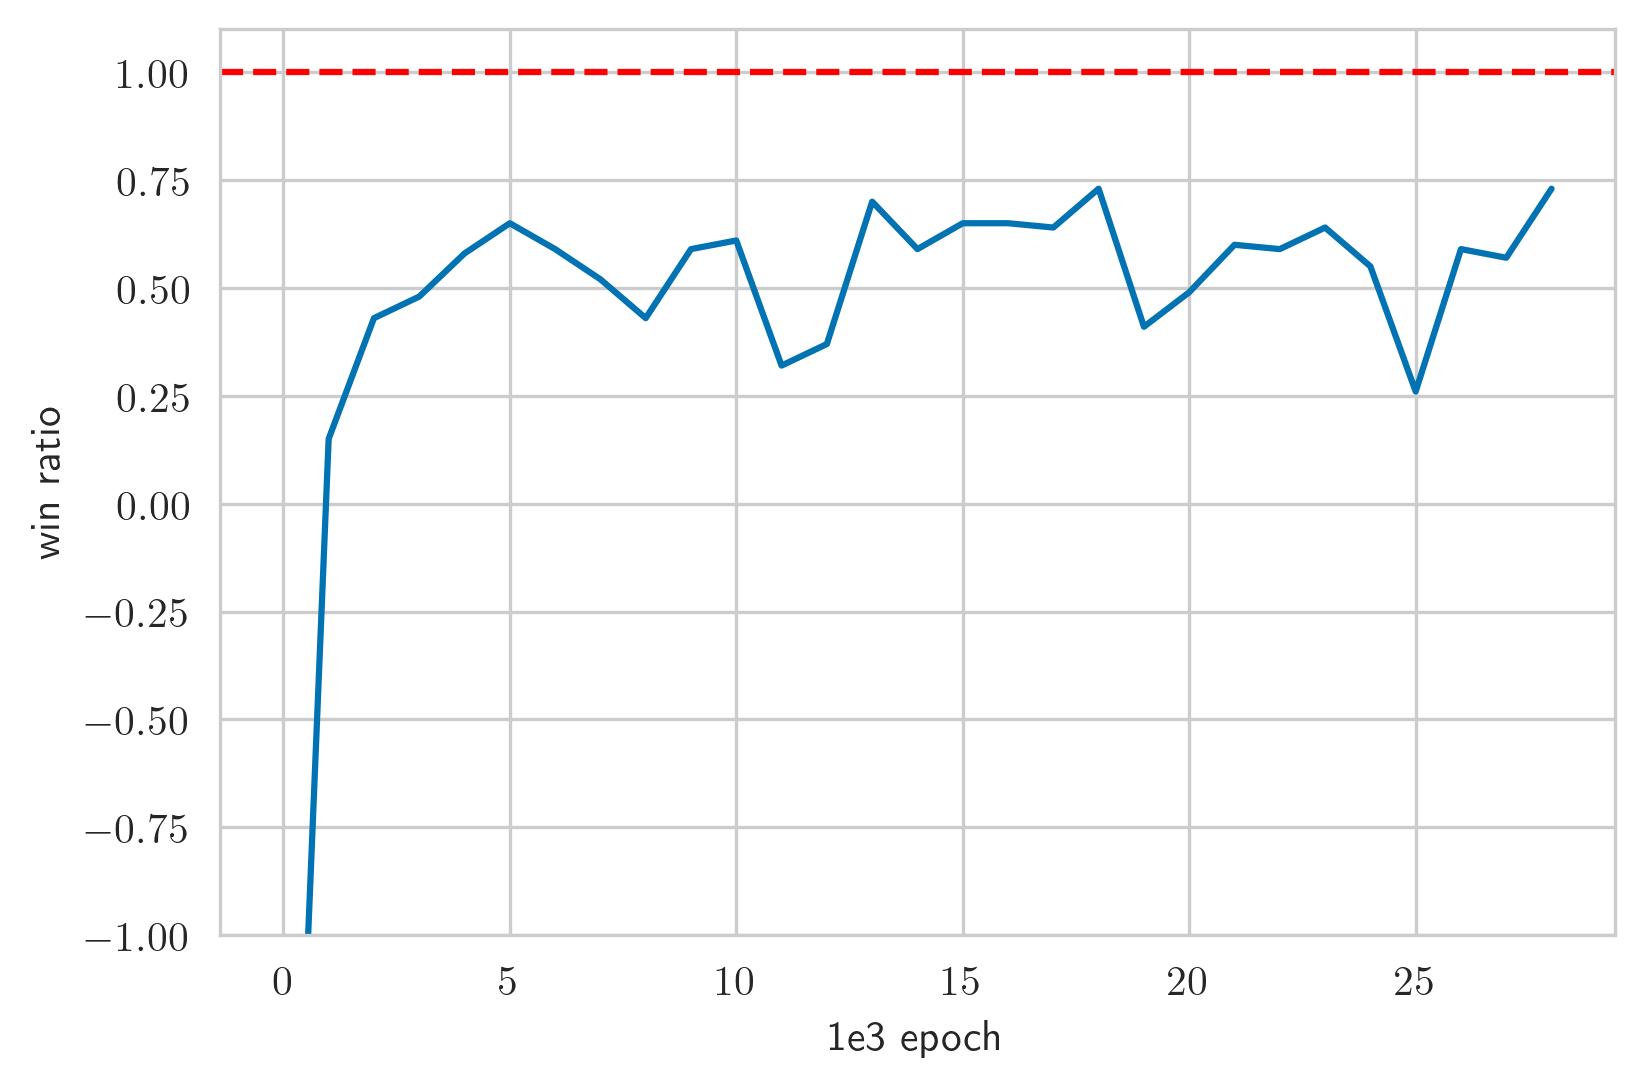

In [719]:
plt.plot([sum(ddqn.rewards[(i * 100): ((i + 1) * 100)]) / 100  for i in range(29)])
plt.ylim(bottom=-1, top=1.1)
plt.ylabel('win ratio')
plt.xlabel('1e3 epoch')
plt.axhline(y=1, color='r', linestyle='--')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


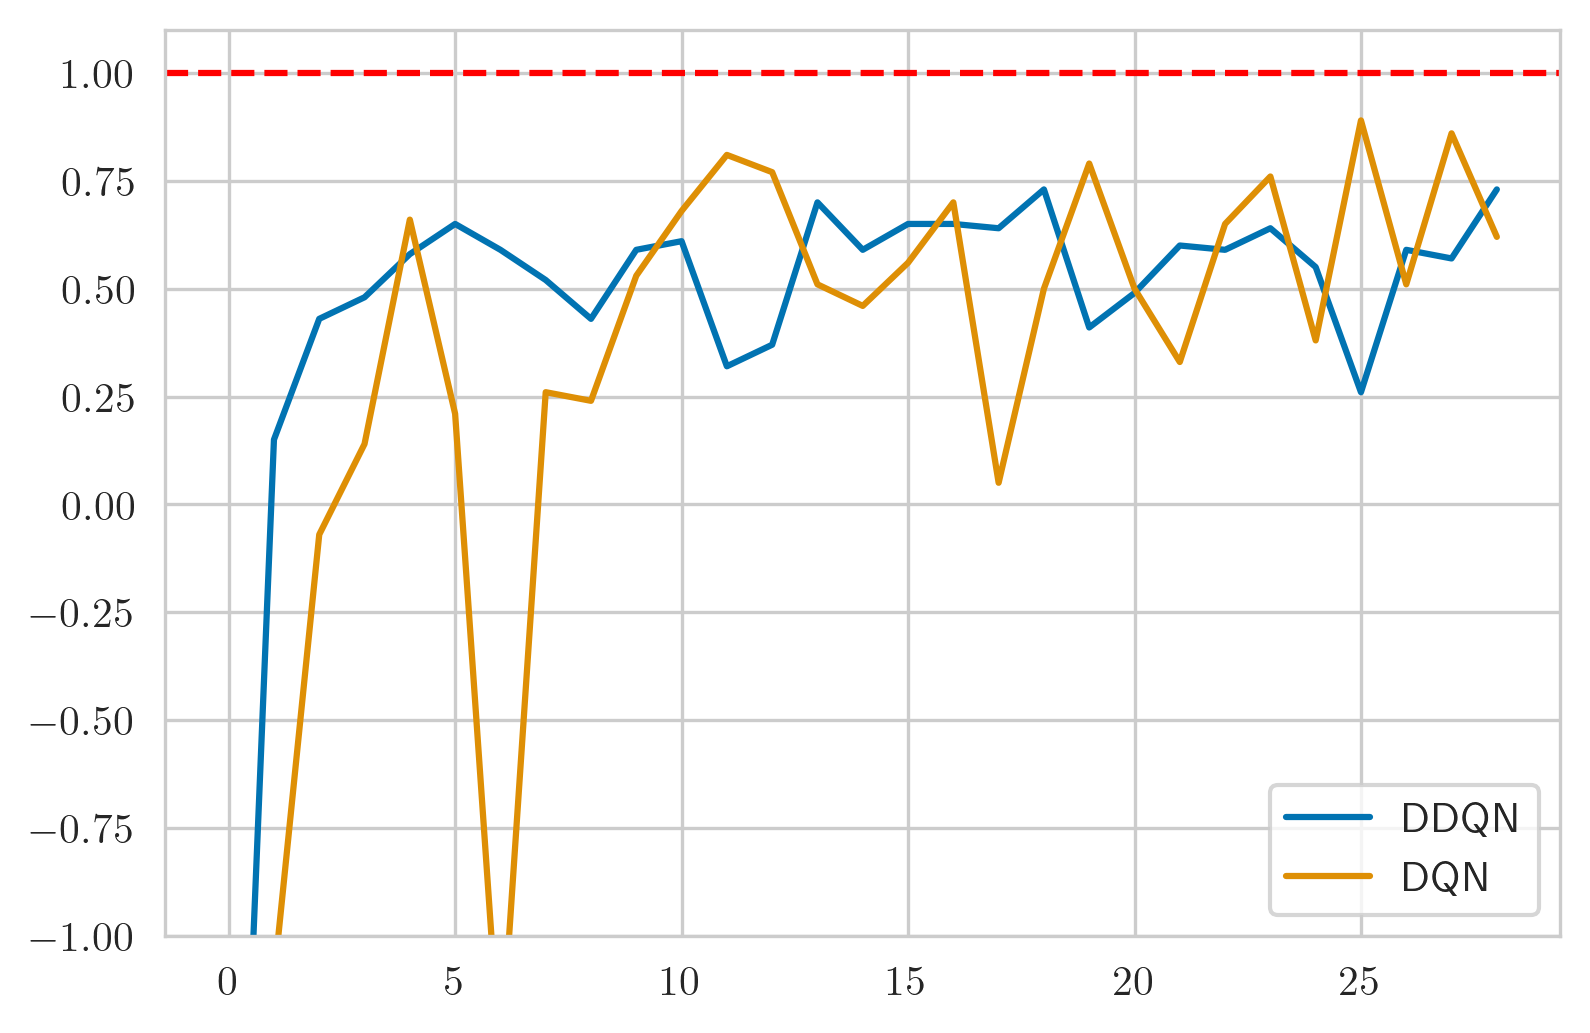

In [721]:
plt.plot([sum(ddqn.rewards[(i * 100): ((i + 1) * 100)]) / 100 for i in range(29)])
plt.plot([sum(dqn.rewards[(i * 100): ((i + 1) * 100)]) / 100 for i in range(29)])
plt.legend(['DDQN', 'DQN'])
plt.ylim(bottom=-1, top=1.1)
plt.axhline(y=1, color='r', linestyle='--')

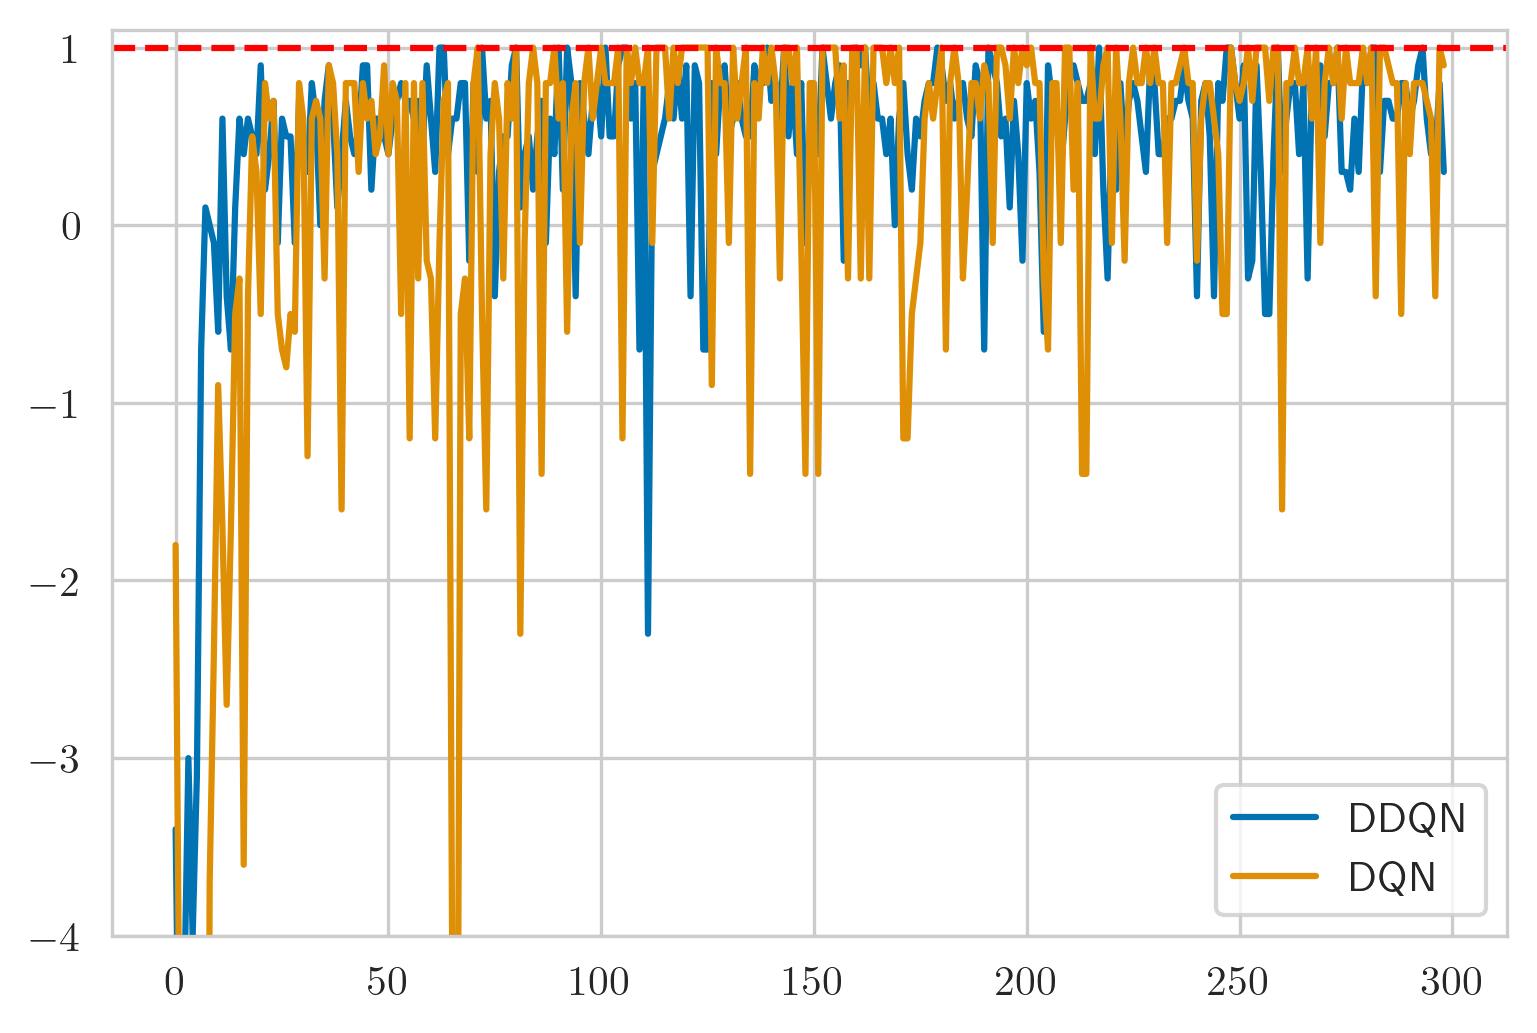

In [724]:
plt.plot([sum(ddqn.rewards[(i * 10): ((i + 1) * 10)]) / 10 for i in range(299)])
plt.plot([sum(dqn.rewards[(i * 10): ((i + 1) * 10)]) / 10 for i in range(299)])
plt.ylim(bottom=-4, top=1.1)
plt.legend(['DDQN', 'DQN'])
plt.axhline(y=1, color='r', linestyle='--')

Double DQN даже при такой же архитектуре с этим небольшим хаком намного быстрее обучается и делает меньше ошибок 